# Projet Produit Structuré

In [1]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import strategy as strat
import matplotlib.pyplot as plt

## Data Retrieving

### Eonia Index et EURIBOR pour le taux sans risque (data récupéré de blom à la date du 11 juin)

In [2]:
marketRates = pd.Series()
marketRates[0.002688] = -0.00476
marketRates[0.083333] = -0.00549
marketRates[0.25]=-0.00545
marketRates[0.5]=-0.00519
marketRates[1.0]=-0.005126
marketRates[2.0]=-0.004821
marketRates[3.0]=-0.00432
marketRates[4.0]=-0.003672
marketRates[5.0]=-0.002960
marketRates[6.0]=-0.002208
marketRates[7.0]=-0.001447
marketRates[8.0]=-0.000697
marketRates[9.0]=0.000040
marketRates[10.0]=0.000718
marketRates[15.0]=0.00338
marketRates[20.0]=0.004563
marketRates[30.0]=0.004683

In [3]:
## Prix historique et Vol historiques 260D du sous-jacent récupéré de bloomberg
data_historic = pd.read_excel("Historic_Data.xlsx")
data_historic.set_index(["Dates"],inplace=True)

### PS Parameters

In [4]:
date_exercice = dt.datetime(2018,1,18)
strike = data_historic.loc[date_exercice]["PX_LAST"]
flt_barrier_bonus = 0.7
redemption_level = 100
flt_bonus = 5.5
capital_barrier = 0.6

In [5]:
S_init = [data_historic.iloc[-1,0]] ##on va commencer la diffusion en utilisant le prix du 8/06/2021
vol = pd.Series([data_historic.iloc[-1,-1]])/100
div = pd.Series([0.0267])### Projected 12M Div Yield, retrieve from Bloomberg
cal_date = data_historic.index[-1]#.date() ## au 8/06/2021
first_observation = dt.datetime(2019,1,11)
last_observation = dt.datetime(2028,1,11)
s_date_index = pd.date_range(first_observation.replace(day=1), last_observation, freq = "12MS") + pd.offsets.Day(first_observation.day-2) + pd.offsets.BDay(1)
int_nbre_date = len(s_date_index) - list(cal_date>s_date_index).index(False) + 1

In [6]:
## payment date : on crée la série des dates de payments utilisée pour déterminer le Discount Factor
payment_init = dt.datetime(2019,1,18)
maturity = dt.datetime(2028,1,18)
s_payment_index = pd.date_range(payment_init.replace(day=1), maturity, freq = "12MS") + pd.offsets.Day(payment_init.day-2) + pd.offsets.BDay(1)

s_calcul_date = s_date_index[list(cal_date<s_date_index)]
s_calcul_date = [d.date() for d in s_calcul_date]
s_payment_date = s_date_index[list(cal_date<s_payment_index)]
s_payment_date = [d.date() for d in s_payment_date]

## Calcul du Timestep
timestep = pd.Series()
delta = pd.Series()
timestep[cal_date.date()] = 0
delta[cal_date.date()] = 0

d_ex = cal_date.date()
for d in s_calcul_date:
    timestep[d] = (d-cal_date.date()).days/365
    delta[d] = (d-d_ex).days/365
    d_ex = d
    
paymentstep = pd.Series()
paymentstep[cal_date.date()] = 0
d_ex = cal_date.date()
for d in s_payment_date:
    paymentstep[d] = (d-cal_date.date()).days/365
    d_ex = d
    
forwarddiscount = []
forwarddiscount.append(0)
for i in range(1,int_nbre_date):
    index_sup = list(paymentstep[i] > marketRates.index).index(False)
    ## interpolation selon la formule de Taylor-Young : f(x) = f(a) + (f(b)-f(a)) * (x-a)/(b-a)
    forwarddiscount.append(marketRates.iloc[index_sup-1] + (marketRates.iloc[index_sup]-marketRates.iloc[index_sup-1])*(paymentstep[i]-marketRates.index[index_sup-1])/(marketRates.index[index_sup]-marketRates.index[index_sup-1]))

    
DF = []
spread = 0
DF.append(0)
DF.append(1/((1+forwarddiscount[1]+spread)**paymentstep[1]))
for i in range(2,len(forwarddiscount)):
    d_t = paymentstep[i] - paymentstep[i-1]
    DF.append(DF[i-1]/((1+forwarddiscount[i])**d_t))
    
riskfree = []
riskfree.append(0)
for i in range(1,int_nbre_date):
    index_sup = list(timestep[i] > marketRates.index).index(False)
    ## interpolation selon la formule de Taylor-Young : f(x) = f(a) + (f(b)-f(a)) * (x-a)/(b-a)
    riskfree.append(marketRates.iloc[index_sup-1] + (marketRates.iloc[index_sup]-marketRates.iloc[index_sup-1])*(timestep[i]-marketRates.index[index_sup-1])/(marketRates.index[index_sup]-marketRates.index[index_sup-1]))

## Constatation Historique

In [7]:
s_historic = s_date_index[list(cal_date>s_date_index)]
s_historic = [d.date() for d in s_historic]
historic = data_historic.loc[s_historic]["PX_LAST"]

In [8]:
coupon_du = 0
for t in range(len(historic)):
    if historic.iloc[t] >= strike*flt_barrier_bonus:
        coupon_du +=1
coupon_du

3

## Diffusion BS

In [9]:
int_nbre_path = 10000
gauss = np.random.normal(0,1,size=(int_nbre_path,int_nbre_date - 1,1))
matrice_alea = gauss * vol.values

In [10]:
diffusion_matrix = strat.Generate_Trajectory_BS(S_init, riskfree, div, vol, delta, np.random.normal(0,1,size=(int_nbre_path,int_nbre_date - 1,1)) * vol.values, int_nbre_path)

## Payoff

In [11]:
#diffusion_matrix = strat.Generate_Trajectory_BS(S_init, riskfree, div, vol, delta, np.random.normal(0,1,size=(int_nbre_path,int_nbre_date - 1,1)) * vol.values, nbre_path = 10000)
histo = pd.DataFrame(np.zeros(diffusion_matrix[0].shape)) #permet de récupérer les cash flows 
price = pd.DataFrame(np.zeros(diffusion_matrix[0].shape))

#coupon dû (payé à maturité)
coupon_infine = pd.DataFrame(np.zeros(diffusion_matrix[0].shape)) + coupon_du

        
for t in range(1,len(diffusion_matrix)):
    #barrière de bonus
    isbonus = diffusion_matrix[t] >= strike*flt_barrier_bonus
    coupon_infine = coupon_infine + (isbonus)
    
    if t == (len(diffusion_matrix)-1): 
    #maturity case
        #payement des coupons dû à maturité
        price = price + DF[t] * coupon_infine * flt_bonus 
        histo = histo + coupon_infine * flt_bonus
        
        #au dessus de la barrière de capital qd produit non expiré : remboursement de 100% du nominal
        isabovecapital = diffusion_matrix[t] >= strike*capital_barrier
        price = price + DF[t] * redemption_level * (isabovecapital)
        histo = histo + redemption_level * (isabovecapital)

        #en dessous du capital : remboursement (diffusion_matrix[t] / strike) %
        price = price + DF[t] * 100 * diffusion_matrix[t] / strike  * (~isabovecapital)
        histo = histo+ 100 * diffusion_matrix[t] / strike * (~isabovecapital)
    
price.mean()

0    136.920263
dtype: float64

#### Avec le modèle de BS, on price l'Anthemis à 136.92%

## Grecques

#### Delta du PS

In [19]:
S_up = [S_init[0] * 1.05]
S_down = [S_init[0] * 0.95]

In [20]:
diffusion_matrix_up = strat.Generate_Trajectory_BS(S_up, riskfree, div, vol, delta, matrice_alea, nbre_path = 10000)
prix_up = strat.Pricing_Anthemis(diffusion_matrix_up,coupon_du,strike,flt_barrier_bonus,DF,flt_bonus,capital_barrier,redemption_level)

In [21]:
diffusion_matrix_down = strat.Generate_Trajectory_BS(S_down, riskfree, div, vol, delta, matrice_alea, nbre_path = 10000)
prix_down = strat.Pricing_Anthemis(diffusion_matrix_down,coupon_du,strike,flt_barrier_bonus,DF,flt_bonus,capital_barrier,redemption_level)

In [29]:
delta_ps = (prix_up - prix_down) / (2 * 0.05)
delta_ps

62.885427004262624

#### Delta

In [13]:
bump = 5
spot = np.arange(0.2,2,0.01) * strike

In [14]:
price_delta = []
for i in range(len(spot)):
    diffusion_matrix = strat.Generate_Trajectory_BS(spot[i], riskfree, div, vol, delta, matrice_alea, nbre_path = 10000)
    price_delta.append(strat.Pricing_Anthemis(diffusion_matrix,coupon_du,strike,flt_barrier_bonus,DF,flt_bonus,capital_barrier,redemption_level))

In [36]:
Delta = (pd.Series(price_delta[bump:])-pd.Series(price_delta[0:-bump]))/(2*bump)

Text(0.5, 1.0, 'Delta')

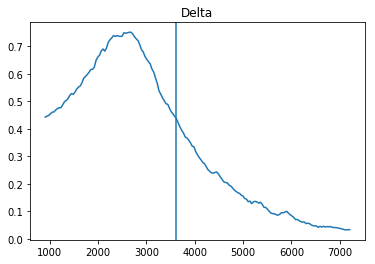

In [37]:
plt.plot(spot[bump:],Delta)
plt.axvline(x=strike)
plt.title("Delta")

#### Gamma

Text(0.5, 1.0, 'Gamma')

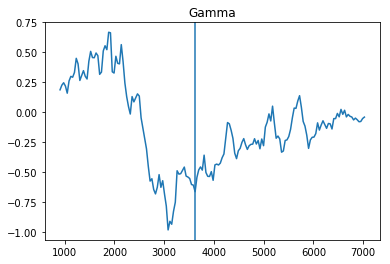

In [29]:
gamma = (pd.Series(price_delta[2*bump:]) + pd.Series(price_delta[0:-2*bump]) - 2 * pd.Series(price_delta[bump:-bump]))
plt.plot(spot[bump:-bump],gamma)
plt.axvline(x=strike)
plt.title("Gamma")

#### Vega

In [38]:
bump = 0.01
price_vega_up = []
price_vega_down = []
for i in range(len(spot)):
    diffusion_matrix_up = strat.Generate_Trajectory_BS(spot[i], riskfree, div, vol + bump, delta, matrice_alea, nbre_path = 10000)
    price_vega_up.append(strat.Pricing_Anthemis(diffusion_matrix_up,coupon_du,strike,flt_barrier_bonus,DF,flt_bonus,capital_barrier,redemption_level))
    diffusion_matrix_down = strat.Generate_Trajectory_BS(spot[i], riskfree, div, vol - bump, delta, matrice_alea, nbre_path = 10000)
    price_vega_down.append(strat.Pricing_Anthemis(diffusion_matrix_down,coupon_du,strike,flt_barrier_bonus,DF,flt_bonus,capital_barrier,redemption_level))

Text(0.5, 1.0, 'Vega')

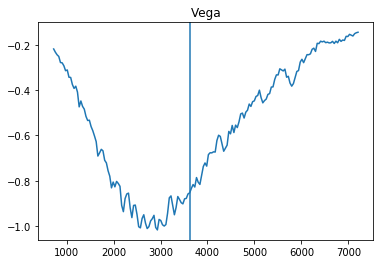

In [39]:
vega = (pd.Series(price_vega_up) - pd.Series(price_vega_down))/(2*bump*100)
plt.plot(spot,vega)
plt.axvline(x=strike)
plt.title("Vega")

## Diffusion Heston

In [40]:
V0 = vol[0]**2;
Eta = 1.5 #vol de vol (ie) variance
Theta = vol[0]**2 #Dans le modèle, on simule la variance => Theta = variance à l'infini, variance long terme
Kappa = 2 #force de retour à la moyenne (ie) mean reversion
Rho = -0.85 #corrélation entre les 2 lois normales (ie) le spot et la vol

#### Riskfree pour la diffusion d'Heston

In [41]:
dT=0.01 #pr une année qui contient 252 jours, cela correspon à ~2jours
Dates=np.arange(0,timestep.iloc[-1],dT)
Dates=sorted(list(set().union(Dates,timestep.values)));
riskfree_heston = []
riskfree_heston.append(0)
for i in range(1,len(Dates)):
    index_sup = list(Dates[i] > marketRates.index).index(False)
    ## interpolation selon la formule de Taylor-Young : f(x) = f(a) + (f(b)-f(a)) * (x-a)/(b-a)
    riskfree_heston.append(marketRates.iloc[index_sup-1] + (marketRates.iloc[index_sup]-marketRates.iloc[index_sup-1])*(Dates[i]-marketRates.index[index_sup-1])/(marketRates.index[index_sup]-marketRates.index[index_sup-1]))

In [42]:
Normal_Maxtrix_Temp = np.random.normal(0,1,size=(int_nbre_path,len(Dates) - 1,1))
Normal_Maxtrix_Spot = np.random.normal(0,1,size=(int_nbre_path,len(Dates) - 1,1))

In [43]:
dict_heston = strat.Generate_Trajectory_Heston(S_init,riskfree_heston,div,timestep,V0,Eta,Theta,Kappa,Rho,int_nbre_path,Normal_Maxtrix_Spot,Normal_Maxtrix_Temp)

In [44]:
diffusion_heston = dict_heston["diffusion"]

In [45]:
strat.Pricing_Anthemis(diffusion_heston,coupon_du,strike,flt_barrier_bonus,DF,flt_bonus,capital_barrier,redemption_level)

102.83889562047888

#### Avec le modèle d'Heston, on price l'Anthemis à 102.83%

### Grecques

### Sensibilité au RHO

In [46]:
eps = 0.05
Rho_up = Rho+eps
Rho_down = Rho-eps

dict_heston_up = strat.Generate_Trajectory_Heston(S_init,riskfree_heston,div,timestep,V0,Eta,Theta,Kappa,Rho_up,int_nbre_path,Normal_Maxtrix_Spot,Normal_Maxtrix_Temp)
dict_heston_down = strat.Generate_Trajectory_Heston(S_init,riskfree_heston,div,timestep,V0,Eta,Theta,Kappa,Rho_down,int_nbre_path,Normal_Maxtrix_Spot,Normal_Maxtrix_Temp)

diffusion_heston_up = dict_heston_up["diffusion"]
diffusion_heston_down = dict_heston_down["diffusion"]

In [51]:
P_up = strat.Pricing_Anthemis(diffusion_heston_up,coupon_du,strike,flt_barrier_bonus,DF,flt_bonus,capital_barrier,redemption_level)
P_down = strat.Pricing_Anthemis(diffusion_heston_down,coupon_du,strike,flt_barrier_bonus,DF,flt_bonus,capital_barrier,redemption_level)

grec_rho = (P_up - P_down)/(2*eps)
grec_rho

-7.464534120571926

### Sensibilité Eta

In [52]:
eps = 0.1
Eta_up = Eta+eps
Eta_down = Eta-eps

dict_heston_eta_up = strat.Generate_Trajectory_Heston(S_init,riskfree_heston,div,timestep,V0,Eta_up,Theta,Kappa,Rho,int_nbre_path,Normal_Maxtrix_Spot,Normal_Maxtrix_Temp)
dict_heston_eta_down = strat.Generate_Trajectory_Heston(S_init,riskfree_heston,div,timestep,V0,Eta_down,Theta,Kappa,Rho,int_nbre_path,Normal_Maxtrix_Spot,Normal_Maxtrix_Temp)

diffusion_heston_eta_up = dict_heston_eta_up["diffusion"]
diffusion_heston_eta_down = dict_heston_eta_down["diffusion"]

In [55]:
P_eta_up = strat.Pricing_Anthemis(diffusion_heston_eta_up,coupon_du,strike,flt_barrier_bonus,DF,flt_bonus,capital_barrier,redemption_level)
P_eta_down = strat.Pricing_Anthemis(diffusion_heston_eta_down,coupon_du,strike,flt_barrier_bonus,DF,flt_bonus,capital_barrier,redemption_level)

grec_eta = (P_eta_up - P_eta_down)/(2*eps)
grec_eta

-30.619599817379353

In [37]:
Eta_null = 0
dict_heston_eta_null = strat.Generate_Trajectory_Heston(S_init,riskfree_heston,div,timestep,V0,Eta_null,Theta,Kappa,Rho,int_nbre_path,Normal_Maxtrix_Spot,Normal_Maxtrix_Temp)

diffusion_heston_eta_null = dict_heston_eta_null["diffusion"]
P_eta_null = strat.Pricing_Anthemis(diffusion_heston_eta_null,coupon_du,strike,flt_barrier_bonus,DF,flt_bonus,capital_barrier,redemption_level)

In [38]:
P_eta_null

136.70541114864773